In [2]:
# !pip install IPython
from IPython.display import Image

In [ ]:
!git clone https://github.com/Im-JihyunKim/2023_LG_ES_SSL_2.git # colab 사용시

-----------------------

# [Self-supervised Learning] Barlow Twins

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 모듈 불러오기

In [1]:
import os, random
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader, Subset  # Dataset과 dataloader를 기반으로 미니배치 학습, 데이터 셔플, 병렬 처리까지 간단하게 수행 가능하도록 지원
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from PIL import ImageOps

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\JihyunKim\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [2]:
'''
seed 정의
https://hoya012.github.io/blog/reproducible_pytorch/
'''
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 2. Custom Dataset 정의
- 방대한 데이터를 batch 단위로 쪼개서 불러올 수 있도록 정의해주는 과정 (기존에는 모든 데이터셋을 한꺼번에 처리)
- Custom Dataset은 가변 길이 input이나 batch를 만들어줄 때 필요  
- 본 튜토리얼에서는 증강된 이미지도 함께 불러와야 하기에 이를 가져올 수 있는 Custom Dataset을 정의할 것임  
cf. https://didu-story.tistory.com/85

### CIFAR10 Dataset

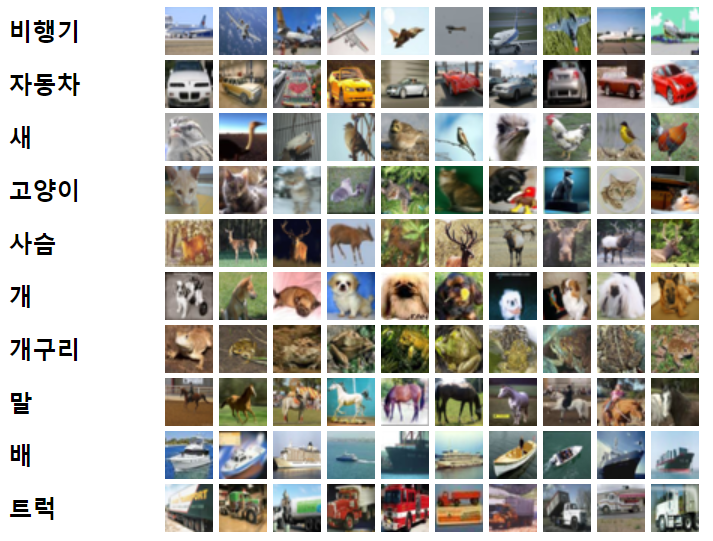

In [7]:
Image('image/cifar10.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/cifar10.PNG') # colab 사용시

- 32x32의 RGB 이미지로 구성된 데이터셋
  - 총 60,000개의 데이터가 있으며 일반적으로 50,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 50,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 따로 지정하지 않음)
- 10개의 class를 분류하는 image classification task에 주로 활용

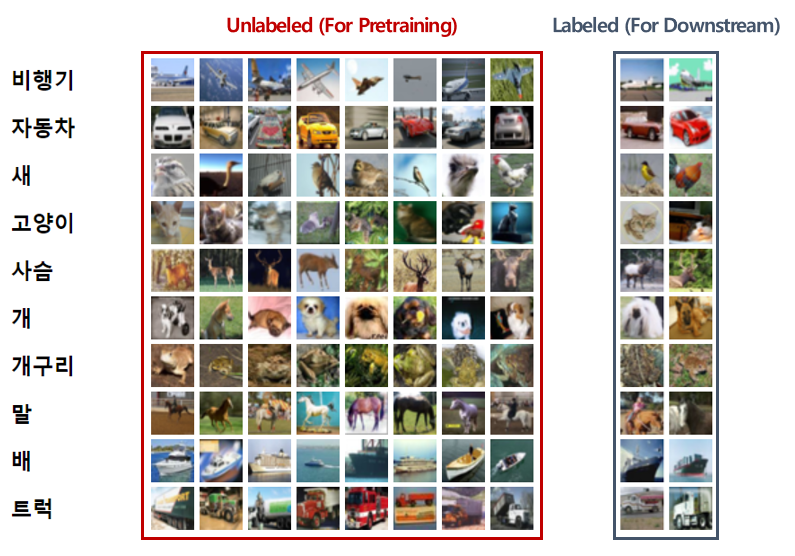

In [8]:
Image('image/Cifar10_dataset.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/Cifar10_dataset.PNG') # colab 사용시

In [3]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data_dir:str):
        self.data_dir = data_dir

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(data_dir, exist_ok=True)


    # For BYOL : BYOL 사전학습 시 사용되는 데이터셋
    def get_pretrain_dataset(self):
        pretrain_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=MultiViewGenerator(  # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                 base_transforms=self.get_transform(size=32)),  # 사전에 정의한 이미지 변형 방법 적용
                                             download=True)
        return pretrain_dataset
    
    # For Downstream task : Downstream 지도학습에 사용되는 데이터
    def get_dataset(self, mode: str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), test_size=0.2, random_state=2023)

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        

    @staticmethod  # 해당 클래스에서만 사용되는 메소드
    def get_transform(size: int=32, s:int=1):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        - SImCLR에서는 augmentation에 대해서 'random crop and resize', 'color distortion', 'blur'가 결합된 augmentation이 좋은 성능을 도출한다고 설명
        """
        normalize = transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010)
        )
        color_jitter = transforms.ColorJitter(0.8 * s, 
                                              0.8 * s,
                                              0.8 * s,
                                              0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms
    

########################################################################################################################################

class MultiViewGenerator(object):
    """
    Take two random crops of one image as the query and key.
    """
    def __init__(self, base_transforms):
        self.transforms = base_transforms
    
    def __call__(self, x):
        output1 = self.transforms(x)
        output2 = self.transforms(x)
        
        output = [output1, output2]
        
        return output

### CIFAR 10 Augmented examples 확인

Files already downloaded and verified


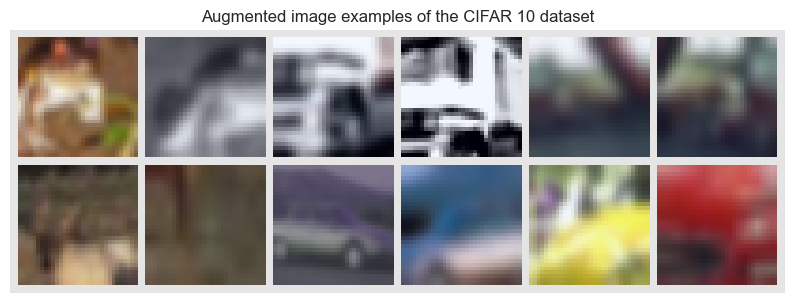

In [12]:
data_dir = './data/'
# data_dir = '/content/2023_LG_ES_SSL_2/data/'   # colab 사용 시

# load dataset
Cifar10 = CIFAR10Dataset(data_dir)
Cifar10_dataset = Cifar10.get_pretrain_dataset()

# call imgs
imgs = torch.stack([img for idx in range(6) for img in Cifar10_dataset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

# visualization
plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the CIFAR 10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## 3. Barlow Twins 네트워크 정의
* Backbone : ResNet
* Projection : MLP

__Barlow Twins__
- 기존의 Contrastive Learning 방법론의 한계를 극복하고자 하였음
  1. 굉장히 큰 batch size를 요구하여 대용량 컴퓨터 자원을 필요로 함
  2. 어떤 데이터 증강 기법(augmentation)을 적용하는가에 따라 성능 편차가 존재
  3. 적절한 negative pair를 선정하거나 정의하기 어려움
- BYOL처럼 두 개의 모델을 이용하지도 않음
- __2개의 augmentation에 대한 representation 값을 유사하게 만드는 학습 방식__
  - 동일한 이미지에서 나온 서로 다른 이미지(view)는, 같은 의미를 담고 있으니 임베딩 벡터 값 간 교차 상관 계수(Cross-correlation)에서 대각 성분이 1이 되어야 함

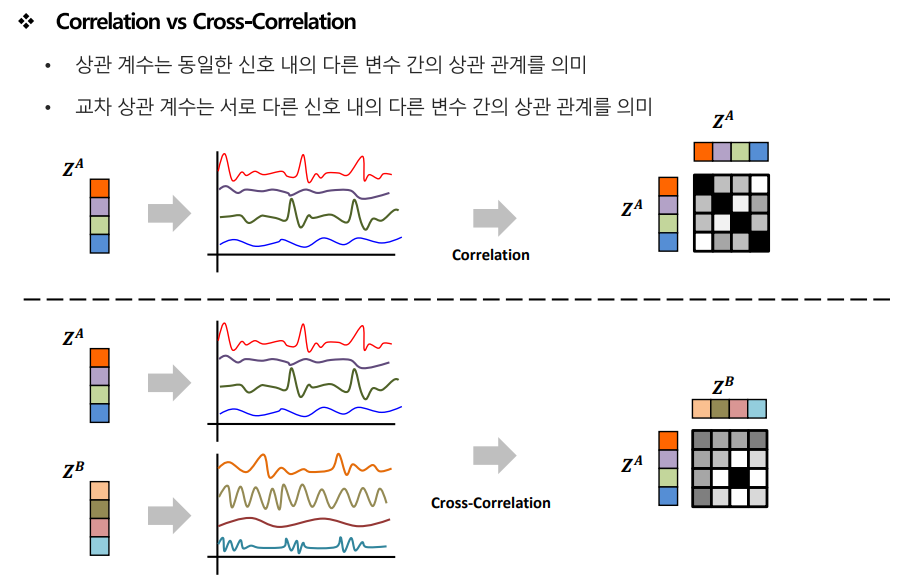

In [3]:
Image('image/BT0.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/BT0.PNG') # colab 사용시

In [4]:
class ResNet(nn.Module):
    def __init__(self, base_model: str, hidden_size: int, projection_size: int):
        super(ResNet, self).__init__()

        self.resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   # ResNet layer 개수에 따라 다른 backbone 선정
            'resnet50': models.resnet50(pretrained=False)
        }

        resnet = self.get_basemodel(base_model)

        # Define CNN encoder
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1])
        
        # Define MLP Projection
        self.projection = MLPHead(in_channels=resnet.fc.in_features,
                                  mlp_hidden_size=hidden_size,
                                  projection_size=projection_size)
        
    def forward(self, x: torch.Tensor):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        
        return self.projection(h)
    
    def get_basemodel(self, model_name: str = None):
        
        model = self.resnet_dict[model_name]
        
        return model
    

######################################################################################################

class MLPHead(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size):
        super(MLPHead, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size, bias=False), 
            nn.BatchNorm1d(mlp_hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size, bias=False)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

## 4. Barlow Twins 학습 정의

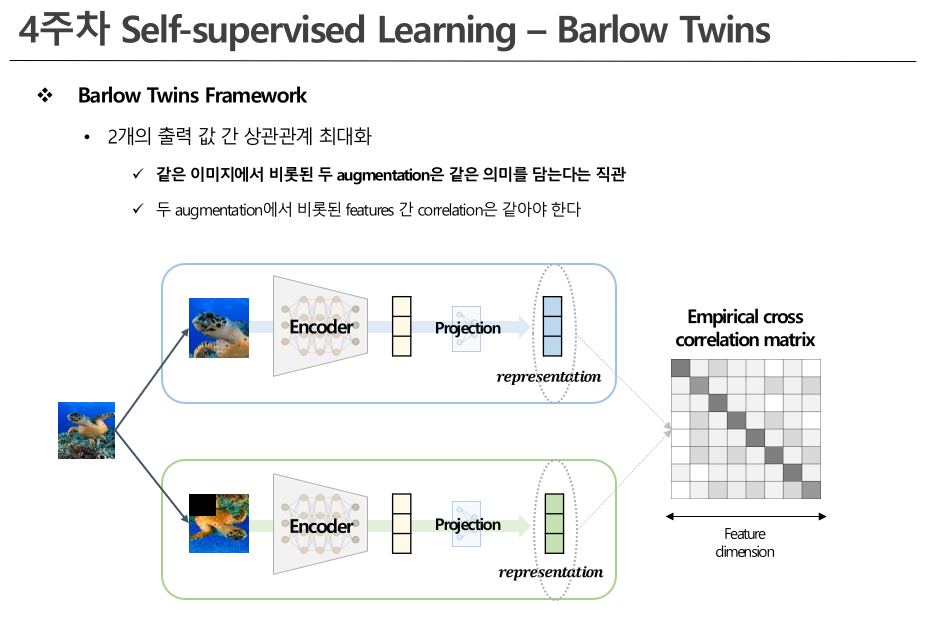

In [4]:
# Image('image/BT.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_2/image/byol_framework.PNG') # colab 사용시

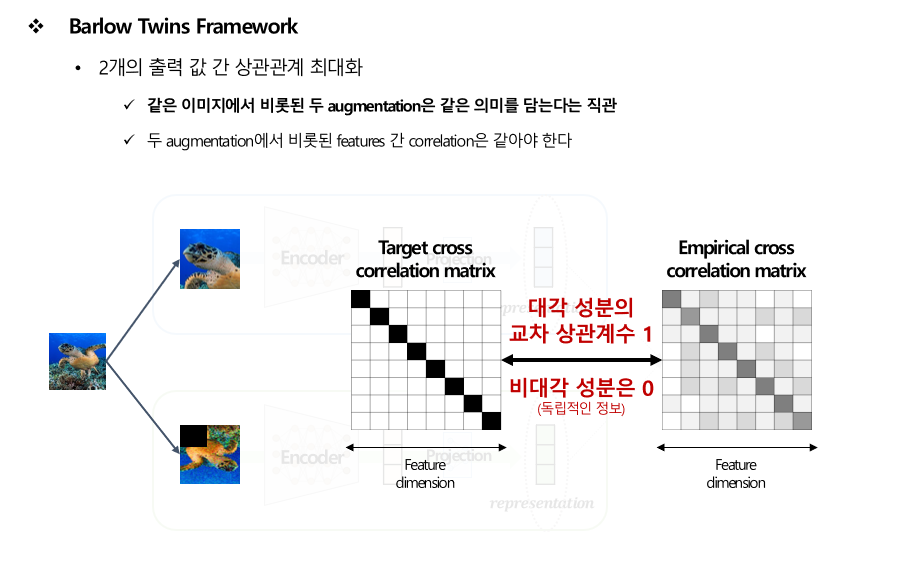

In [8]:
Image('image/BT2.PNG') # 로컬 사용시
# Image('/content/2023_LG_ES_SSL_2/image/BT2.PNG') # colab 사용시

### Barlow Twins 모델 학습 방식

In [5]:
class Barlow_Trainer(object):
    def __init__(self, device, model, **kwargs):
        self.device = device
        self.model = model.to(self.device)

        self.__dict__.update(kwargs)

    def barlow_loss(self, z1, z2, lam = 5e-3):
        batch_size = z1.size(0)
        emb_size = z1.size(1)

        # Normalization for the representations z1 and z2
        z1_norm = (z1 - z1.mean(0)) / z1.std(0)
        z2_norm = (z2 - z2.mean(0)) / z2.std(0)

        # empirical cross-correlation matrix
        cross_correlation_mat = (z1_norm.T @ z2_norm) / batch_size
        
        loss = (cross_correlation_mat*lam - torch.eye(emb_size, device=self.device)*lam).pow(2) # .pow() taks the power of each element in input
        
        return loss.sum()
    
    def pretrain(self, train_loader):
        # make checkpoint directory
        os.makedirs(self.ckpt_dir, exist_ok=True)

        n_iter = 0
        for epoch in range(self.epochs):
            train_loss = 0

            for (img_aug_1, img_aug_2), _ in tqdm(train_loader):
                img_aug_1 = img_aug_1.to(self.device)
                img_aug_2 = img_aug_2.to(self.device)

                z1 = self.model(img_aug_1)
                z2 = self.model(img_aug_2)

                loss = self.barlow_loss(z1, z2)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss
                
                if n_iter % self.logging_steps == 0:
                    print(f'Loss: {loss} \n')
                
                n_iter += 1
            
            train_loss /= (len(train_loader))
            
            print('=' * 30)
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n')
        
        # Save the model
        torch.save(self.model.state_dict(), os.path.join(self.ckpt_dir, 'pretrained_BarlowTwins.pt'))

        return self.model

## Barlow Twins 코드 실행

In [6]:
def main(device, configs: dict):

    # define dataset, dataloader
    dataset = CIFAR10Dataset(data_dir=configs['data_dir'])   # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'

    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)

    # definde model, optimizer, learning rate scheduler
    model = ResNet(
        base_model=configs['backbone'],
        hidden_size=configs['hidden_size'],
        projection_size=configs['projection_size']
    )

    optimizer = torch.optim.SGD(model.parameters(),
                                lr = configs['learning_rate'],
                                weight_decay = configs['weight_decay'])

    trainer = Barlow_Trainer(
        model=model,
        device=device,
        optimizer=optimizer,
        batch_size = configs['batch_size'],
        epochs = configs['epochs'],
        logging_steps = configs['logging_steps'],
        ckpt_dir = configs['ckpt_dir'],
        )
        
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    configs = {'data_dir': './data/',    # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'
               'ckpt_dir':'./ckpt_dir/BarlowTwins', # local: './ckpt_dir/BarlowTwins' or colab:'/content/2023_LG_ES_SSL_2/ckpt_dir/BarlowTwins'
               'batch_size': 256, 'epochs': 5, 'logging_steps': 20, 
               'learning_rate': 3e-3, 'weight_decay':1.5e-6,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'num_worker': 0}
    
    pretrained_model = main(device, configs)

Files already downloaded and verified


  1%|          | 1/195 [00:03<11:53,  3.68s/it]

Loss: 0.0047508119605481625 



 11%|█         | 21/195 [00:18<02:04,  1.40it/s]

Loss: 0.005048851482570171 



 21%|██        | 41/195 [00:32<01:54,  1.35it/s]

Loss: 0.0046836151741445065 



 31%|███▏      | 61/195 [00:47<01:39,  1.35it/s]

Loss: 0.004489736631512642 



 42%|████▏     | 81/195 [01:02<01:25,  1.34it/s]

Loss: 0.00459707248955965 



 52%|█████▏    | 101/195 [01:17<01:08,  1.36it/s]

Loss: 0.004982140846550465 



 62%|██████▏   | 121/195 [01:32<00:57,  1.29it/s]

Loss: 0.004691544454544783 



 72%|███████▏  | 141/195 [01:49<00:42,  1.26it/s]

Loss: 0.005017660558223724 



 83%|████████▎ | 161/195 [02:04<00:25,  1.34it/s]

Loss: 0.0046142651699483395 



 93%|█████████▎| 181/195 [02:19<00:10,  1.28it/s]

Loss: 0.004667218774557114 



100%|██████████| 195/195 [02:30<00:00,  1.30it/s]


Epoch: 1 
Loss: 0.004794019274413586 



  3%|▎         | 6/195 [00:04<02:26,  1.29it/s]

Loss: 0.004774438217282295 



 13%|█▎        | 26/195 [00:19<02:05,  1.34it/s]

Loss: 0.005365998484194279 



 24%|██▎       | 46/195 [00:34<02:00,  1.23it/s]

Loss: 0.004898395389318466 



 34%|███▍      | 66/195 [00:49<01:45,  1.23it/s]

Loss: 0.00468797143548727 



 44%|████▍     | 86/195 [01:04<01:23,  1.30it/s]

Loss: 0.004868779331445694 



 54%|█████▍    | 106/195 [01:19<01:05,  1.35it/s]

Loss: 0.00461580790579319 



 65%|██████▍   | 126/195 [01:33<00:49,  1.39it/s]

Loss: 0.004758410155773163 



 75%|███████▍  | 146/195 [01:48<00:39,  1.25it/s]

Loss: 0.004621495027095079 



 85%|████████▌ | 166/195 [02:03<00:21,  1.37it/s]

Loss: 0.004652789793908596 



 95%|█████████▌| 186/195 [02:17<00:06,  1.36it/s]

Loss: 0.00489870086312294 



100%|██████████| 195/195 [02:24<00:00,  1.35it/s]


Epoch: 2 
Loss: 0.0047883144579827785 



  6%|▌         | 11/195 [00:08<02:14,  1.37it/s]

Loss: 0.005033127497881651 



 16%|█▌        | 31/195 [00:22<01:58,  1.38it/s]

Loss: 0.004616630729287863 



 26%|██▌       | 51/195 [00:37<01:44,  1.37it/s]

Loss: 0.004853691905736923 



 36%|███▋      | 71/195 [00:51<01:31,  1.35it/s]

Loss: 0.004826472140848637 



 47%|████▋     | 91/195 [01:06<01:21,  1.28it/s]

Loss: 0.00483030267059803 



 57%|█████▋    | 111/195 [01:21<01:01,  1.37it/s]

Loss: 0.004822134971618652 



 67%|██████▋   | 131/195 [01:36<00:49,  1.30it/s]

Loss: 0.004603271838277578 



 77%|███████▋  | 151/195 [01:50<00:32,  1.36it/s]

Loss: 0.004584725946187973 



 88%|████████▊ | 171/195 [02:05<00:18,  1.31it/s]

Loss: 0.005087034776806831 



 98%|█████████▊| 191/195 [02:20<00:03,  1.32it/s]

Loss: 0.004685996100306511 



100%|██████████| 195/195 [02:22<00:00,  1.36it/s]


Epoch: 3 
Loss: 0.004770289640873671 



  8%|▊         | 16/195 [00:11<02:10,  1.37it/s]

Loss: 0.004703431855887175 



 18%|█▊        | 36/195 [00:26<01:56,  1.37it/s]

Loss: 0.004777394235134125 



 29%|██▊       | 56/195 [00:41<01:45,  1.31it/s]

Loss: 0.0047874776646494865 



 39%|███▉      | 76/195 [00:55<01:27,  1.37it/s]

Loss: 0.004752561450004578 



 49%|████▉     | 96/195 [01:10<01:17,  1.28it/s]

Loss: 0.004581783898174763 



 59%|█████▉    | 116/195 [01:25<00:57,  1.38it/s]

Loss: 0.004567816853523254 



 70%|██████▉   | 136/195 [01:40<00:43,  1.34it/s]

Loss: 0.004697979893535376 



 80%|████████  | 156/195 [01:55<00:29,  1.31it/s]

Loss: 0.004951153416186571 



 90%|█████████ | 176/195 [02:09<00:14,  1.31it/s]

Loss: 0.0046486021019518375 



100%|██████████| 195/195 [02:23<00:00,  1.35it/s]


Epoch: 4 
Loss: 0.004779963754117489 



  1%|          | 1/195 [00:00<02:54,  1.11it/s]

Loss: 0.004664749372750521 



 11%|█         | 21/195 [00:15<02:13,  1.30it/s]

Loss: 0.004852551035583019 



 21%|██        | 41/195 [00:30<01:58,  1.30it/s]

Loss: 0.0049954745918512344 



 31%|███▏      | 61/195 [00:45<01:42,  1.31it/s]

Loss: 0.004887568764388561 



 42%|████▏     | 81/195 [00:59<01:26,  1.32it/s]

Loss: 0.004680707585066557 



 52%|█████▏    | 101/195 [01:14<01:08,  1.37it/s]

Loss: 0.0047288695350289345 



 62%|██████▏   | 121/195 [01:29<00:54,  1.36it/s]

Loss: 0.0047718193382024765 



 72%|███████▏  | 141/195 [01:43<00:39,  1.37it/s]

Loss: 0.004737694747745991 



 83%|████████▎ | 161/195 [01:58<00:24,  1.38it/s]

Loss: 0.0048474702052772045 



 93%|█████████▎| 181/195 [02:12<00:10,  1.31it/s]

Loss: 0.004870229866355658 



100%|██████████| 195/195 [02:23<00:00,  1.36it/s]

Epoch: 5 
Loss: 0.004778970032930374 



## Barlow Twins로 사전 학습한 인코더를 사용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [7]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    """
    Computes the accuracy over the top k predictions
    for the specified values of k
    - Top-1 Accuracy: softmax의 output에서 제일 높은 수치(confidence)를 가지는 확률 값이 실제 정답일 경우에 대한 지표 계산
    - Top-n Accuracy : softmax output 중 상위 n개의 확률 값을 가지는 클래스 중 실제 정답이 있는 경우에 대한 지표 계산
    """
    with torch.no_grad():
        max_k = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [8]:
class Downstream(object):
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device

        self.encoder = encoder.to(device)   # 사전학습 된 encoder 불러오기
        self.classifier = classifier.to(device)
        self.optimizer = optimizer

        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                # Freeze Encoder Parameters (사전학습된 인코더의 파라미터는 업데이트 하지 않음)
                if self.downstream:
                    with torch.no_grad():
                        logits = self.encoder(images)
                        logits = logits.squeeze()
                else:
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            # Test
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
        
        return self.encoder, self.classifier

In [9]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader   
    Cifar10_dataset = CIFAR10Dataset(data_dir=configs['data_dir'])  # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
        # load pretrained encoder
    model = ResNet(
                    base_model=configs['backbone'],
                    hidden_size=configs['hidden_size'],
                    projection_size=configs['projection_size']
                    )
    model.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'], 'pretrained_BarlowTwins.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=model.encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',          # local: './data/' or colab:'/content/2023_LG_ES_SSL_2/data/'
               'ckpt_dir':'./ckpt_dir/BarlowTwins', # local: './ckpt_dir/BarlowTwins' or colab:'/content/2023_LG_ES_SSL_2/ckpt_dir/BarlowTwins'
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 2.3618266582489014 
Top1 Train Accuracy: 12.79296875 
Top1 Test Accuracy: 16.556489944458008 
Top5 Test Accuracy: 61.365684509277344 

Epoch: 2 
Loss: 2.2201976776123047 
Top1 Train Accuracy: 18.59130859375 
Top1 Test Accuracy: 18.84765625 
Top5 Test Accuracy: 67.64573669433594 

Epoch: 3 
Loss: 2.1343464851379395 
Top1 Train Accuracy: 22.27783203125 
Top1 Test Accuracy: 21.563251495361328 
Top5 Test Accuracy: 71.826171875 

Epoch: 4 
Loss: 2.0794451236724854 
Top1 Train Accuracy: 25.244140625 
Top1 Test Accuracy: 22.723857879638672 
Top5 Test Accuracy: 73.31355285644531 

Epoch: 5 
Loss: 2.035053014755249 
Top1 Train Accuracy: 27.20947265625 
Top1 Test Accuracy: 23.56144905090332 
Top5 Test Accuracy: 75.24038696289062 

Epoch: 6 
Loss: 1.9963371753692627 
Top1 Train Accuracy: 28.8330078125 
Top1 Test Accuracy: 24.14738655090332 
Top5 Test Accuracy: 75.8338317871093

----------

### 성능 비교

|   | Supervised Learning | SimCLR Downstream | BYOL Downstream | SimSiam Downstream | Barlow Twins Downstream |
|---| ------------------- | ----------- | --------- | ---- | --- |
|Top 1 Train ACC| 33.46 | 44.54 | 28.31 | 32.14 | 33.01 |
|Top 1 Test ACC| 29.39 | 42.48 | 27.95| 25.94 | 25.87 |
|Top 5 Test ACC| 77.82 | 90.16 | 83.06| 78.08 | 77.46 |